<img src="figures/logos.png" style="float: centre;" width="800"/>

# Volcano practical

## Written for the COMET InSAR Workshop 2022.

Welcome to this COMET practical on measuring volcanic deformation with InSAR.

This practical has been tested in the latest versions of Chrome and Firefox, but should work in most modern browsers.

### Interacting with this practical

To run a cell containing code, you can either press "Run" in the bar above, or press "Shift+Enter".

A "#" indicates a comment within the code. 

##################################### <br />
Blocks of code surrounded by multiple "#" (like this one) indicate variables that you can experiment changing the values to. While you can experiment with the full body of code further (and I encourage you to do so after the course), we are limited in our ability to help you debug any errors you may encounter. Changing just the values indicate should result in no major errors. <br />
#####################################

If you get a "dead kernel" error, either restart the kernel under "Kernel" on the top bar, or reopen the binder fresh. None of your changes here will affect the original binder, so feel free to open the bender fresh if anything breaks.

If no cells are running, check if the notebook says "Not trusted" in the top right corner. If so, click this box and accept the pop-up message.

### Acknowledgements

Detailed guidance on the content was provided by Susanna Ebmeier. Advice on the computational requirements of the practical was provided by Richard Rigby. Thanks to everyone for their contributions.

Andrew Watson - 2021

In [2]:
# Import required modules. Run this before continuing.

# these are for performing the analysis
import numpy as np
import pyproj

# these packages are required for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# this is our own library of functions, which can be found in the same directory as this notebook
import coseis_lib as clib

# this is additional scientific colour maps, see "https://www.fabiocrameri.ch/colourmaps/"
from cmcrameri import cm

# this is our own library of functions, and can be found in the same directory as this practical
import volcano_lib as lib

ModuleNotFoundError: No module named 'pyproj'

## 0. Introduction

Deformation at volcano can be caused by many processes including the movement of magma, volume changes within a reservoir as well as flow subsidence or faulting. Most InSAR studies of volcanic deformation focus on pressure changes related to magmatic processes such as intrusion or eruption, and provide evidence of magma depth, source geometry and change in pressure. Not all erupting volcanoes deform in a manner that we can measure, and much deformation at volcanoes is not directly related to eruptions. However, unrest involving deformation is more likely to be detectable in pre-eruptive periods than other parameters measurable from satellite imagery such as temperature anomalies and gas emission. Deformation measurements are therefore important not only for research into magmatic processes, but also for monitoring volcanic activity.  

Further reading:  
- Pinel, V., Poland, M. P., & Hooper, A. (2014). Volcanology: Lessons learned from synthetic aperture radar imagery. Journal of Volcanology and Geothermal Research, 289, 81-113. 
- Segall, P. (2019). Magma chambers: what we can, and cannot, learn from volcano geodesy. Philosophical Transactions of the Royal Society A, 377(2139), 20180158 
- Ebmeier, S.K., Andrews, B.J., Araya, M.C., Arnold, D.W.D., Biggs, J., Cooper, C., Cottrell, E., Furtney, M., Hickey, J., Jay, J.J.J.A.V. and Lloyd, R., 2018. Synthesis of global satellite observations of magmatic and volcanic deformation: implications for volcano monitoring & the lateral extent of magmatic domains. Journal of Applied Volcanology, 7(1), pp.1-26. 

In this practical we will look at an example of a very simple but widely used analytical deformation source model (Mogi source) and explore the impact of topography and line-of-sight on the predicted displacements. We will then look at a real example from the COMET volcano portal and use forward models to try and match the observed displacements with our simple model.  

A Mogi model is a point-source model used to explain surface deformation above an expanding magma chamber.

<img src="figures/mogi.png" style="float: centre;" width="600"/>

*Figure 1: Schematic diagram of a Mogi source. From Lisowski (2007)*

We make the following assumptions:
- the source is in an isotropic elastic half space, which is defined by the Poisson's ratio $v$, and the Shear modulus $\mu$.
- the radius of the point source is lower than it depth (can't break the surface).
- the magma itself is incompressible.

We can express a mogi source as:

\begin{equation}
\begin{pmatrix} ux \\ uy \\ uz \end{pmatrix} = \alpha^3 \delta P \frac{(1-v)}{\mu} \begin{pmatrix} x / R^3 \\ y / R^3 \\ z / R^3 \end{pmatrix} \qquad \qquad (1)
\end{equation}

where $ux$, $uy$, and $uz$ are the displacements in the x, y, and z axes, respecitvely. \alpha is the radius of the source at depth, $d$, measured to the centre of the source. $\delta P$ is the pressure change in the source. $R$ is the distance between the centre of the source and a position on the ground surface at which the displacements are calculated.

By taking the following approximation:
\begin{equation}
\delta V \approx \frac{\delta P}{\mu} \pi \alpha^3
\end{equation}

where $\delta V$ is the change in volume of the source.

We can rewrite Equation 1 as:

\begin{equation}
\begin{pmatrix} ux \\ uy \\ uz \end{pmatrix} = \delta V \frac{(1-v)}{\pi} \begin{pmatrix} x / R^3 \\ y / R^3 \\ z / R^3 \end{pmatrix} \qquad \qquad (2)
\end{equation}

## 1. Synthetic Mogi Source

Let's start by generating a simple models for an inflating magma chamber - a Mogi source. You can read more about the assumptions behind the Mogi source and about its sensitivity to these assumptions being broken here:  
- Mogi, K. 1958. Relations between the eruptions of various volcanoes and the deformations of the ground surfaces around them. Earthq Res Inst, 36, pp.99-134. 
- Masterlark, T., 2007. Magma intrusion and deformation predictions: Sensitivities to the Mogi assumptions. Journal of Geophysical Research: Solid Earth, 112(B6).

An advantage of InSAR is that it allows measurements over large areas and at postings of every few metres to tens of metres.  Prior to this, most modelling of volcanic deformation sources was done on the basis of a few measurements from levelling, distance meters or GNSS sites along roughly radial lines – similar to a transect through an interferogram. Even if a full 3D displacement field cannot be retrieved, the relationship between vertical and East-West motion can give us some idea of source type and depth.

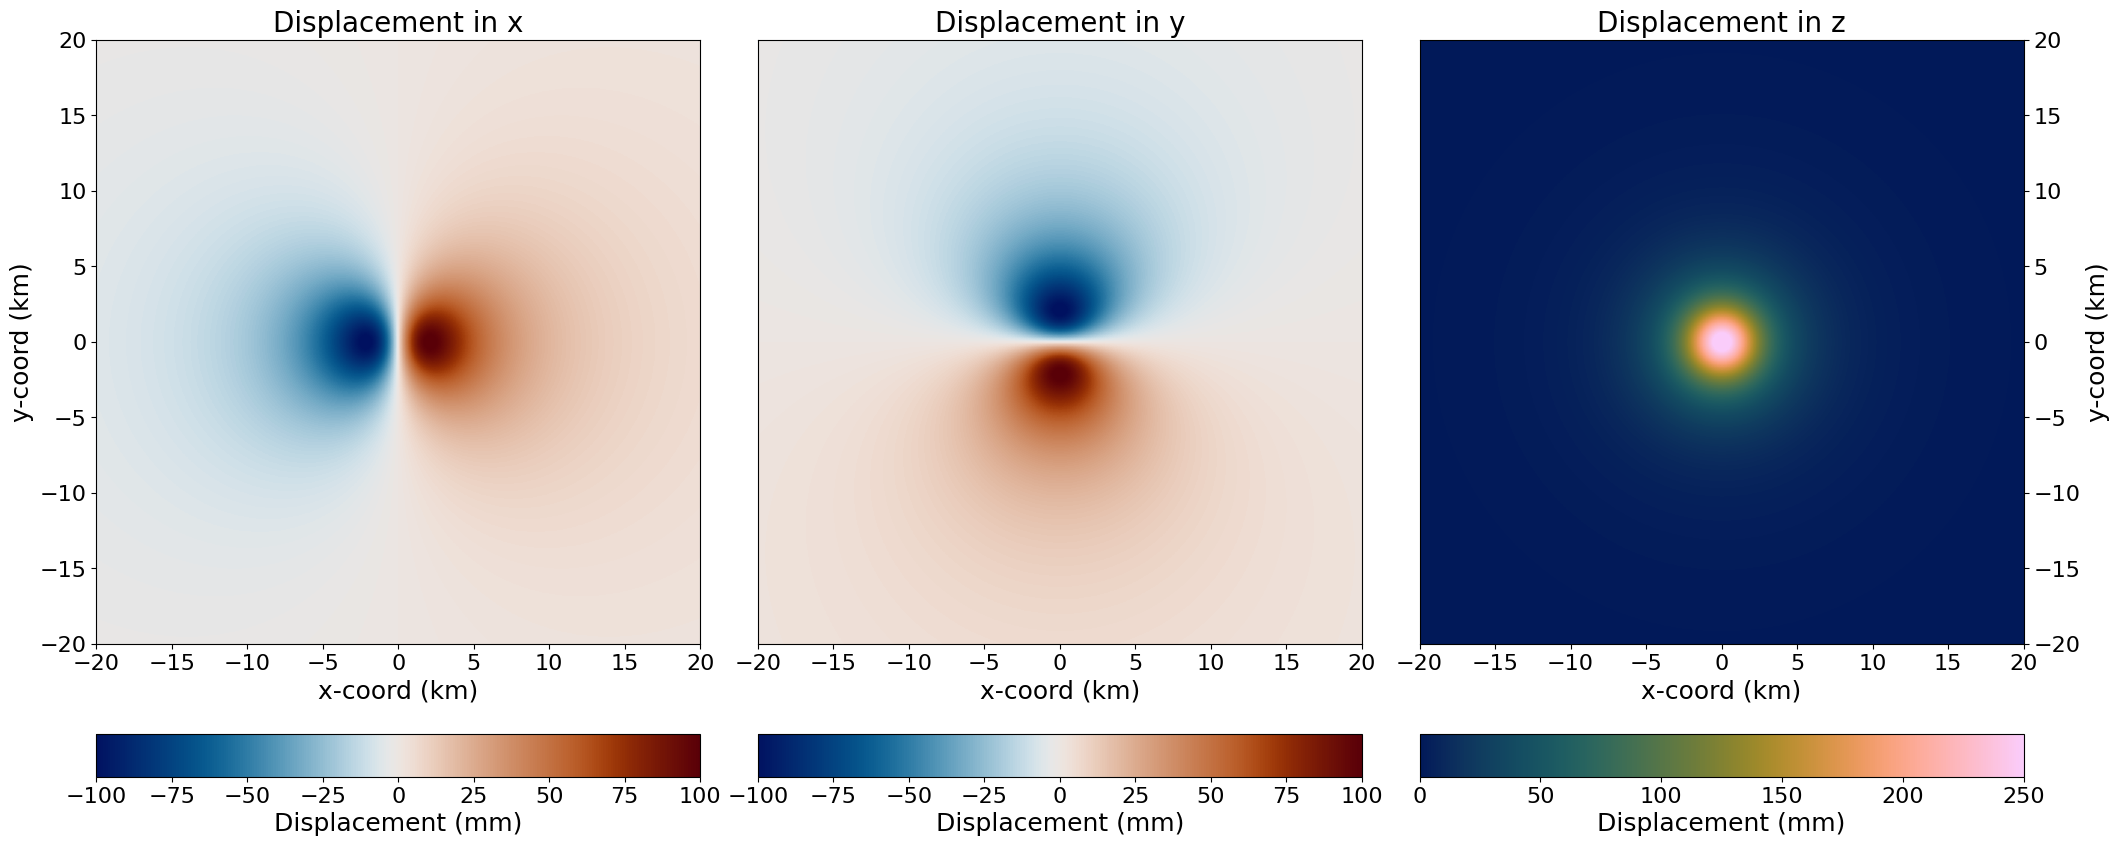

In [2]:
# setup model params
#####################################
source_depth = 3 # depth to point (km)
dV = 1e7 # change in volume (m^3)
#####################################

# setup coord limits in km
xmin, xmax, xint = -20, 20, 0.1
ymin, ymax, yint = -20, 20, 0.1

# make grids of x and y coordinates
x = np.arange(xmin, xmax+xint, xint)
y = np.arange(ymin, ymax+yint, yint)
xx, yy = np.meshgrid(x, y)

# poisson's ratio for medium
nu = 0.25 

# generate displacements using Mogi source (note the unit conversions to metres)
ux, uy, uz = lib.mogi_source(xx*1000, yy*1000, d=source_depth*1000, dV=dV, nu=nu)

# set limits for colour bar, using different limits for z
cmin, cmax = -100, 100
cmin_z, cmax_z = 0, 250

# plot the results
fig, axs = plt.subplots(1,3,figsize=(20,10))
fig.tight_layout()

# displacement in x
im = axs[0].imshow(ux*1000, extent=[xmin, xmax, ymin, ymax], vmin=cmin, vmax=cmax, cmap=cm.vik)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('Displacement in x', fontsize=20)
axs[0].set_xlabel('x-coord (km)', fontsize=18)
axs[0].set_ylabel('y-coord (km)', fontsize=18)
axs[0].tick_params(labelsize=16)

# displacement in y
im = axs[1].imshow(uy*1000, extent=[xmin, xmax, ymin, ymax], vmin=cmin, vmax=cmax, cmap=cm.vik)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1].set_title('Displacement in y', fontsize=20)
axs[1].set_xlabel('x-coord (km)', fontsize=18)
axs[1].tick_params(labelsize=16)
axs[1].set_yticklabels([])
axs[1].set_yticks([])

# displacement in z
im = axs[2].imshow(uz*1000, extent=[xmin, xmax, ymin, ymax], vmin=cmin_z, vmax=cmax_z, cmap=cm.batlow)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[2].set_title('Displacement in z', fontsize=20)
axs[2].set_xlabel('x-coord (km)', fontsize=18)
axs[2].set_ylabel('y-coord (km)', fontsize=18)
axs[2].tick_params(labelsize=16)
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position("right")


Let's also plot these as a single 3D surface displacement map, using colour to show vertical motion, and vectors to show horizontal motion.

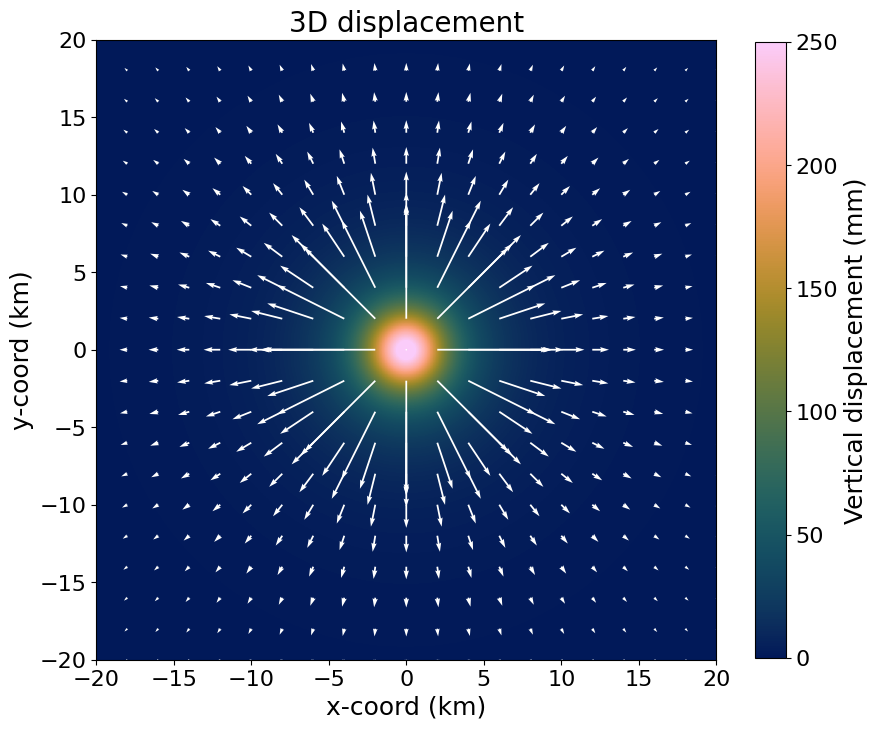

In [3]:
# downsample ux and uy so that we only draw arrows every 2 km
arr_spacing = 2 # km
xstep, ystep = round(arr_spacing/xint), round(arr_spacing/yint)
ux_ds = ux[0::ystep,0::xstep]
uy_ds = uy[0::ystep,0::xstep]
xx_ds = xx[0::ystep,0::xstep]
yy_ds = yy[0::ystep,0::xstep]

# plot figure
fig = plt.figure(figsize=(10,10))
im = plt.imshow(uz*1000, extent=[xmin, xmax, ymin, ymax], vmin=cmin_z, vmax=cmax_z, cmap=cm.batlow)
plt.quiver(xx_ds, yy_ds, ux_ds, uy_ds, color='white')
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label(label='Vertical displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.title('3D displacement', fontsize=20)
plt.xlabel('x-coord (km)', fontsize=18)
plt.ylabel('y-coord (km)', fontsize=18)
plt.tick_params(labelsize=16)

plt.show()

Let's also plot a profile through the $x$ and $u$ displacements at $y=0$.

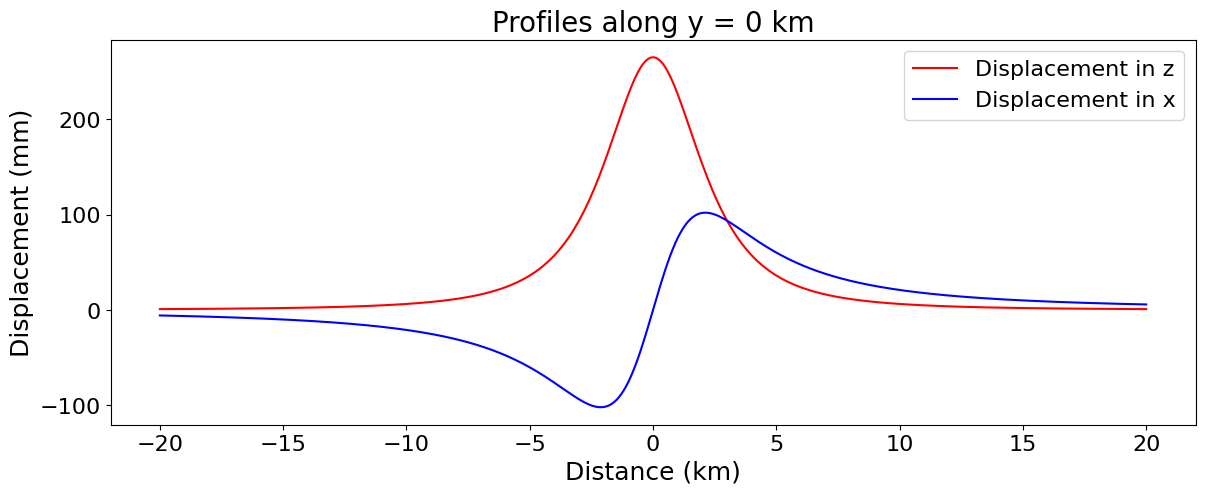

In [4]:
# get indexes of y=0
y0_ind = np.argmin(np.abs(y))

# profile across x=0 using simple indexing
prof_uz = uz[y0_ind,:]
prof_ux = ux[y0_ind,:]

# plot profiles
fig = plt.figure(figsize=(14,5))

plt.plot(x, prof_uz*1000, color='red', label='Displacement in z')
plt.plot(x, prof_ux*1000, color='blue', label='Displacement in x')
plt.legend(fontsize=16)
plt.title('Profiles along y = 0 km', fontsize=20)
plt.xlabel('Distance (km)', fontsize=18)
plt.ylabel('Displacement (mm)', fontsize=18)
plt.tick_params(labelsize=16)

plt.show()

## 2. Impact of Satellite Line-of-Sight

SAR satellite instruments are side looking, and can make measurements in just one dimension, the satellite’s line of sight (LOS). This means that the actual measurements made with InSAR look different to those predicted by our Mogi model.

<img src="figures/line-of-sight.png" style="float: centre;" width="600"/>

*Figure 2: The apparent centre of displacements over a volcano will shift depending on the satellite look direction and incidence angle. From Magee et al. (2018)*

Let's run the model again but include the effect of LOS, starting with a single value for both the satellite heading and the incidence angle. 

An incidence angle of 38° is reasonable for both ascending and descending. In real data, this incidence angle varies across the image, but we'll stick to a fixed value for simplicity. 

For heading, try -170° for ascending, and -10° for descending. See what impact this has on the shape of displacements predicted by the Mogi model by varying these values.

While we don't perform this here, we could combine the different look directions of ascending and descending satellite passes to estimate the East-West and vertical displacements if we assume the 

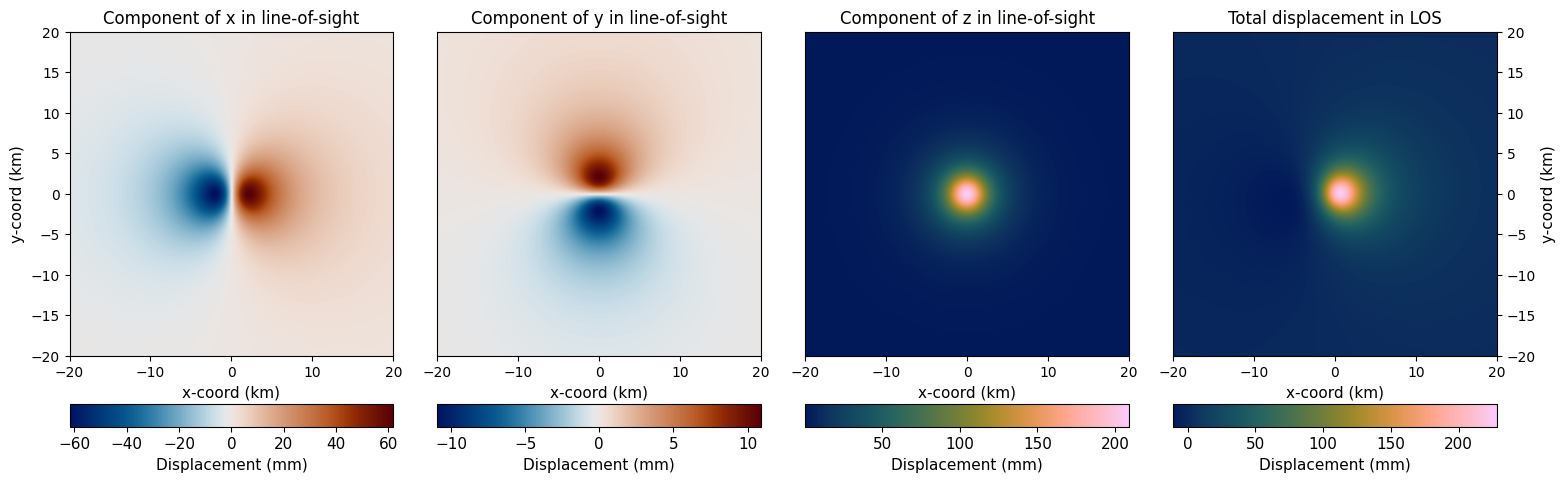

In [5]:
# params
#####################################
heading = -10 # degrees
incidence = 38 # degrees
#####################################

# create grids of these angles
heading_grid = np.ones(xx.shape) * heading
incidence_grid = np.ones(xx.shape) * incidence

# generate conversions for each components to LOS
x2los = np.cos(np.deg2rad(heading_grid)) * np.sin(np.deg2rad(incidence_grid))
y2los = np.sin(np.deg2rad(heading_grid)) * np.sin(np.deg2rad(incidence_grid))
z2los = np.cos(np.deg2rad(incidence_grid))

# apply projection
ux_los = ux * x2los
uy_los = uy * y2los
uz_los = uz * z2los

# calculate total displacement in los 
ulos = ux_los + uy_los + uz_los

# plot our new displacements
fig, axs = plt.subplots(1,4,figsize=(15,10))
fig.tight_layout(w_pad=0.1)

# displacement in x
im = axs[0].imshow(ux_los*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.vik)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=11)
cbar.ax.tick_params(labelsize=11)
axs[0].set_title('Component of x in line-of-sight')
axs[0].set_xlabel('x-coord (km)', fontsize=11)
axs[0].set_ylabel('y-coord (km)', fontsize=11)

# displacement in y
im = axs[1].imshow(uy_los*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.vik)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=11)
cbar.ax.tick_params(labelsize=11)
axs[1].set_title('Component of y in line-of-sight')
axs[1].set_xlabel('x-coord (km)', fontsize=11)
axs[1].set_yticklabels([])
axs[1].set_yticks([])

# displacement in z
im = axs[2].imshow(uz_los*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=11)
cbar.ax.tick_params(labelsize=11)
axs[2].set_title('Component of z in line-of-sight')
axs[2].set_xlabel('x-coord (km)', fontsize=11)
axs[2].set_yticklabels([])
axs[2].set_yticks([])

# displacement in LOS
im = axs[3].imshow(ulos*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
#axs[3].contour(y, x, ulos*1000)
divider = make_axes_locatable(axs[3])
cax = divider.append_axes("bottom", size="7%", pad="15%")
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label(label='Displacement (mm)', fontsize=11)
cbar.ax.tick_params(labelsize=11)
axs[3].set_title('Total displacement in LOS')
axs[3].set_xlabel('x-coord (km)', fontsize=11)
axs[3].set_ylabel('y-coord (km)', fontsize=11)
axs[3].yaxis.tick_right()
axs[3].yaxis.set_label_position("right")

plt.show()

Let's compare our original 3D displacement figure with a wrapped version of our LOS displacements, which should make the change in the shape of the signal more apparent. We'll wrap the data into fringes of 10 mm.

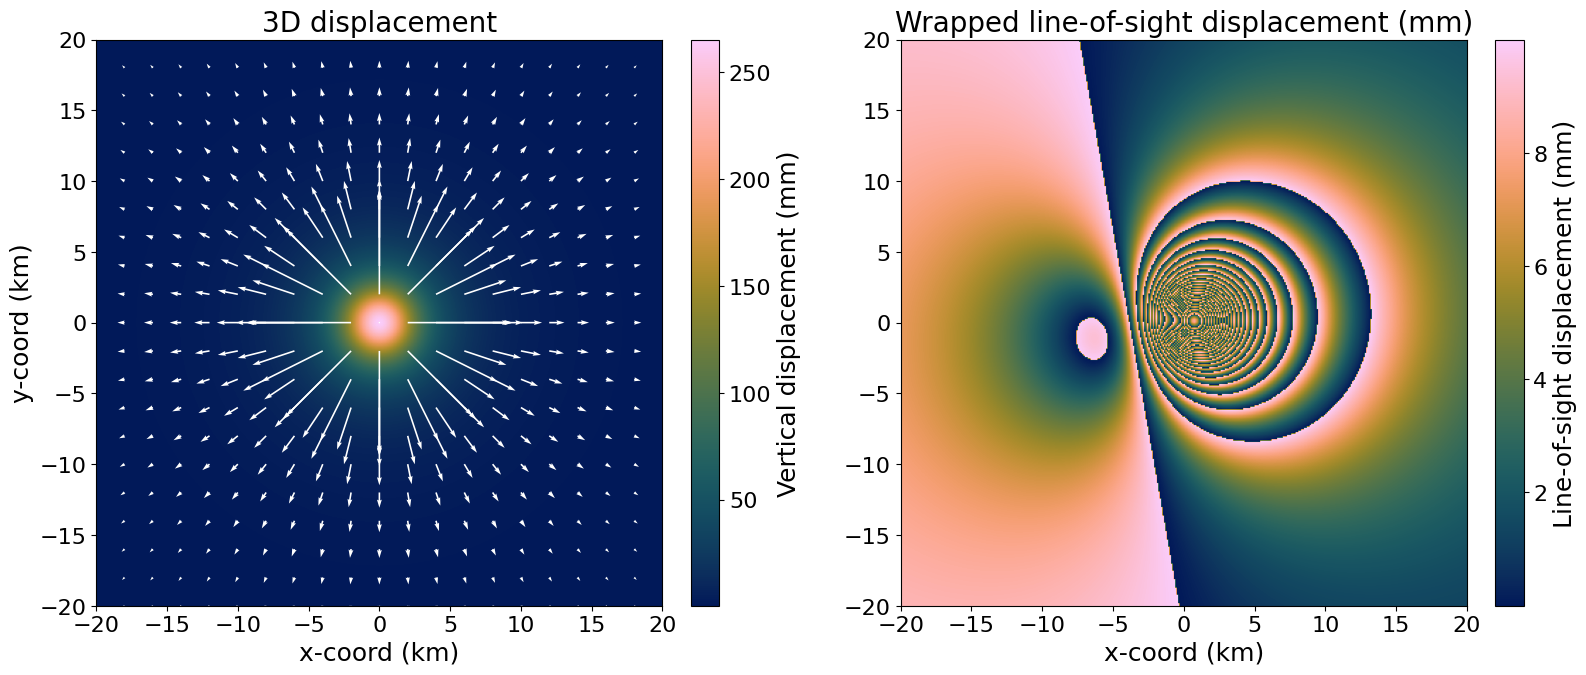

In [6]:
# plot
fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout(w_pad=10)

# 3D displacements
im = axs[0].imshow(uz*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
axs[0].quiver(xx_ds, yy_ds, ux_ds, uy_ds, color='white')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Vertical displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('3D displacement', fontsize=20)
axs[0].set_xlabel('x-coord (km)', fontsize=18)
axs[0].set_ylabel('y-coord (km)', fontsize=18)
axs[0].tick_params(labelsize=16)

# wrapped LOS
im = axs[1].imshow(np.remainder(ulos*1000, 10), extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1].set_title('Wrapped line-of-sight displacement (mm)', fontsize=20)
axs[1].set_xlabel('x-coord (km)', fontsize=18)
axs[1].tick_params(labelsize=16)

plt.show()

Let's again profile the displacements and compare the new LOS displacements to the original x and z displacements.

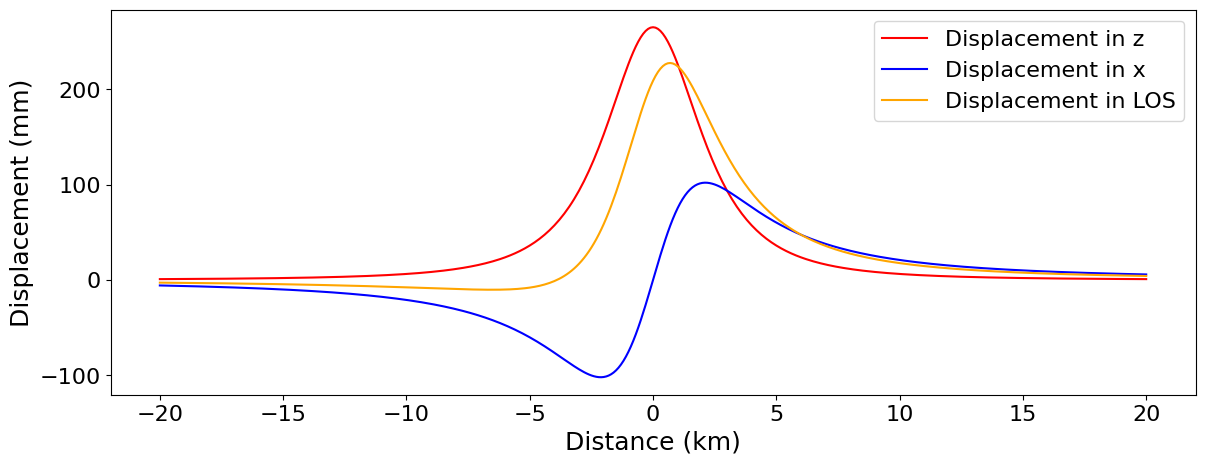

In [7]:
# profile los across y=0
prof_los = ulos[y0_ind,:]

# plot profiles
fig = plt.figure(figsize=(14,5))

plt.plot(x, prof_uz*1000, color='red', label='Displacement in z')
plt.plot(x, prof_ux*1000, color='blue', label='Displacement in x')
plt.plot(x, prof_los*1000, color='orange', label='Displacement in LOS')
plt.legend(fontsize=16)
plt.xlabel('Distance (km)', fontsize=18)
plt.ylabel('Displacement (mm)', fontsize=18)
plt.tick_params(labelsize=16)

plt.show()

## 3. Impact of topography

Our Mogi source currently assumes that the Earth’s surface is entirely flat. In the real world, topography above the source will change the shape and magnitude of displacements at the Earth’s surface. The full impact of topography on the displacements can be assessed using numerical modelling (e.g., finite element or boundary element). 

However, we can make a simple approximation of the effects of topography on our Mogi source by correcting just for the changes in distance between source and the surface by varying the source depth, which is a good approximation of the impact of topography on vertical displacements (Figure 3, Williams and Wadge, 1998).   

<img src="figures/topo_correction.png" style="float: centre;" width="400"/>

*Figure 3: Illustration of the vary-depth approximation for the impact of topography on surface displacements as described by Williams and Wadge (1998).  From Lisowski (2007), Figure 8.32.*

- Williams, C.A. and Wadge, G., 1998. The effects of topography on magma chamber deformation models: Application to Mt. Etna and radar interferometry. Geophysical Research Letters, 25(10), pp.1549-1552. 

We'll load in elevations for Domuyo volcano (more on that below). 

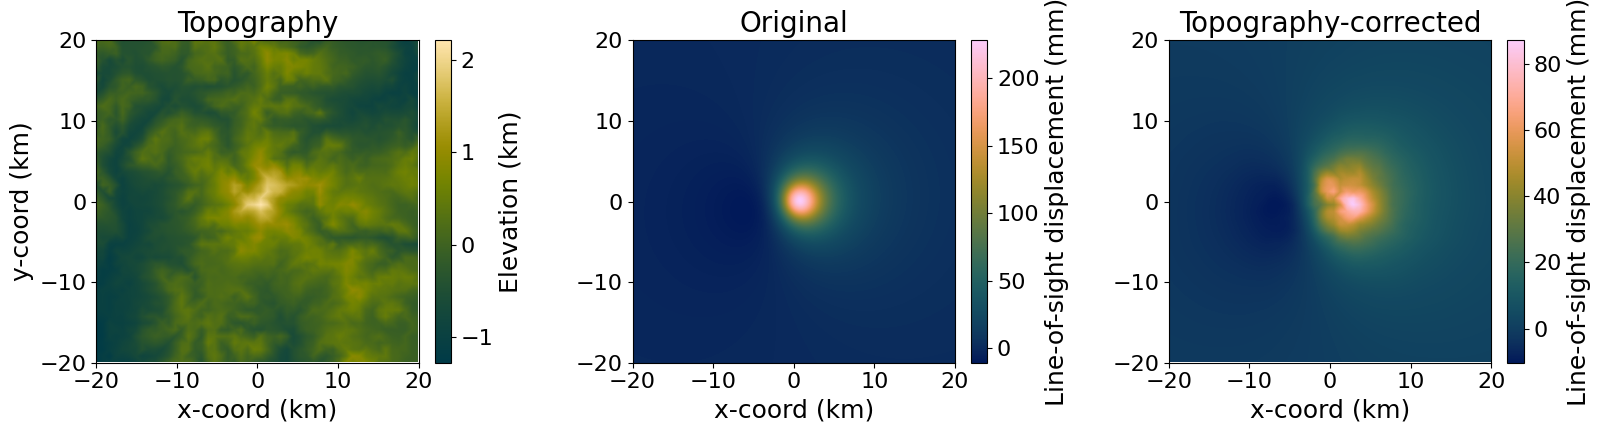

In [8]:
# source parameters
#####################################
source_depth = 3 # depth to point (km)
dV = 1e7 # change in volume (m^3)
nu = 0.25 # poisson's ratio for medium
#####################################

# load in a topography file
synth_elev = np.load('data/synth_dem.npy')

# shift the elevations so that the mean is at 0
synth_elev = synth_elev - np.nanmean(synth_elev)

# generate mogi source with topography
ux_topo, uy_topo, uz_topo = lib.mogi_source_topo(xx*1000, yy*1000, synth_elev, d=source_depth*1000, dV=dV, nu=nu)

# apply projection to LOS
ux_topo_los = ux_topo * x2los
uy_topo_los = uy_topo * y2los
uz_topo_los = uz_topo * z2los

# calculate total displacement in LOS 
ulos_topo = ux_topo_los + uy_topo_los + uz_topo_los

# plot topography, original LOS dispalcements, and topographically corrected LOS displacements
fig, axs = plt.subplots(1,3,figsize=(15,10))
fig.tight_layout(w_pad=10)

# topography
im = axs[0].imshow(synth_elev/1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.bamako)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Elevation (km)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('Topography', fontsize=20)
axs[0].set_xlabel('x-coord (km)', fontsize=18)
axs[0].set_ylabel('y-coord (km)', fontsize=18)
axs[0].tick_params(labelsize=16)

# original LOS
im = axs[1].imshow(ulos*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1].set_title('Original', fontsize=20)
axs[1].set_xlabel('x-coord (km)', fontsize=18)
axs[1].tick_params(labelsize=16)

# topography-corrected
im = axs[2].imshow(ulos_topo*1000, extent=[xmin, xmax, ymin, ymax], cmap=cm.batlow)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[2].set_title('Topography-corrected', fontsize=20)
axs[2].set_xlabel('x-coord (km)', fontsize=18)
axs[2].tick_params(labelsize=16)

plt.show()

Let's take profiles through y = 0 again.

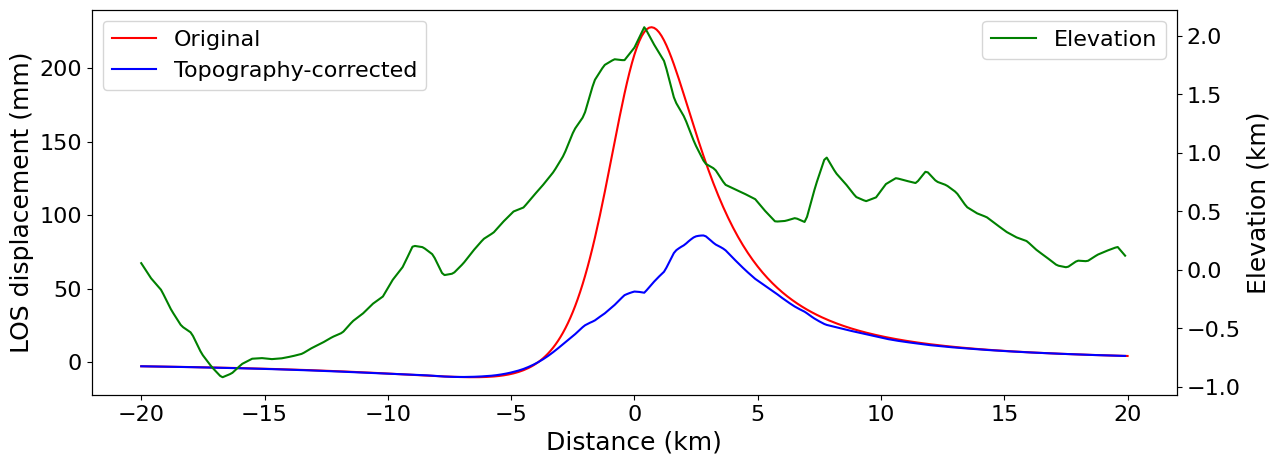

In [9]:
# profile across y=0
prof_u_orig = ulos[y0_ind,:]
prof_u_topo = ulos_topo[y0_ind,:]
prof_elev = synth_elev[y0_ind,:]

# plot profiles
fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(x, prof_u_orig*1000, color='red', label='Original')
ax1.plot(x, prof_u_topo*1000, color='blue', label='Topography-corrected')
ax1.set_xlabel('Distance (km)', fontsize=18)
ax1.set_ylabel('LOS displacement (mm)', fontsize=18)
ax1.tick_params(labelsize=16)
ax1.legend(loc='upper left',fontsize=16)

ax2 = ax1.twinx()
ax2.plot(x, prof_elev/1000, color='green', label='Elevation')
ax2.set_ylabel('Elevation (km)', fontsize=18)  # we already handled the x-label with ax1
ax2.tick_params(labelsize=16)
ax2.legend(fontsize=16)

plt.show()

## 4. Real world example - Domuyo

We'll now apply our Mogi model to a real world example. We'll be looking at Domuyo volcano in Argentina, which showed relatively consistent uplift between 2015 and 2020. Since the end of 2020, the volcano has begun to subside again. We'll model just the 2015-2020 period using our Mogi source. 

Domuyo is a volcanic complex in Argentina with no historical eruptions, but with a geothermal reservoir that extends ~15 km to the southwest of the volcano. It uplifted between 2015 and 2020, coinciding with a period of surface warming (Lundgren et al., 2020).

The time series for Domuyo can be found on the COMET Volcano Portal at:
https://comet.nerc.ac.uk/comet-volcano-portal/volcano-index/South%20America/Argentina/Domuyo/S1_analysis

<img src="figures/Domuyo_from_portal.png" style="float: centre;" width="1000"/>

*Figure 4: Total displacement (left) and the displacement time series (right) from frame 018A_12668_131313 for Domuyo volcano, taken from the COMET Volcano Portal.*

This time series is produced from automatically processed Sentinel-1 imagery – you can read more about how it was constructed and how to interpret it here: https://comet.nerc.ac.uk/comet-volcano-portal/about-tools

Background information on the deformation at Domuyo can be found at:
https://www.nature.com/articles/s41598-020-67982-8

The volcano portal allows us to download a csv showing the cumulative displacement, coherence, and elevation at any time step for every point in the grid. I've provided two of these csv files, which we will load in and regrid.

The columns of these csv files are:
**latitude, longitude, displacement (mm), coherence, elevation (m)**

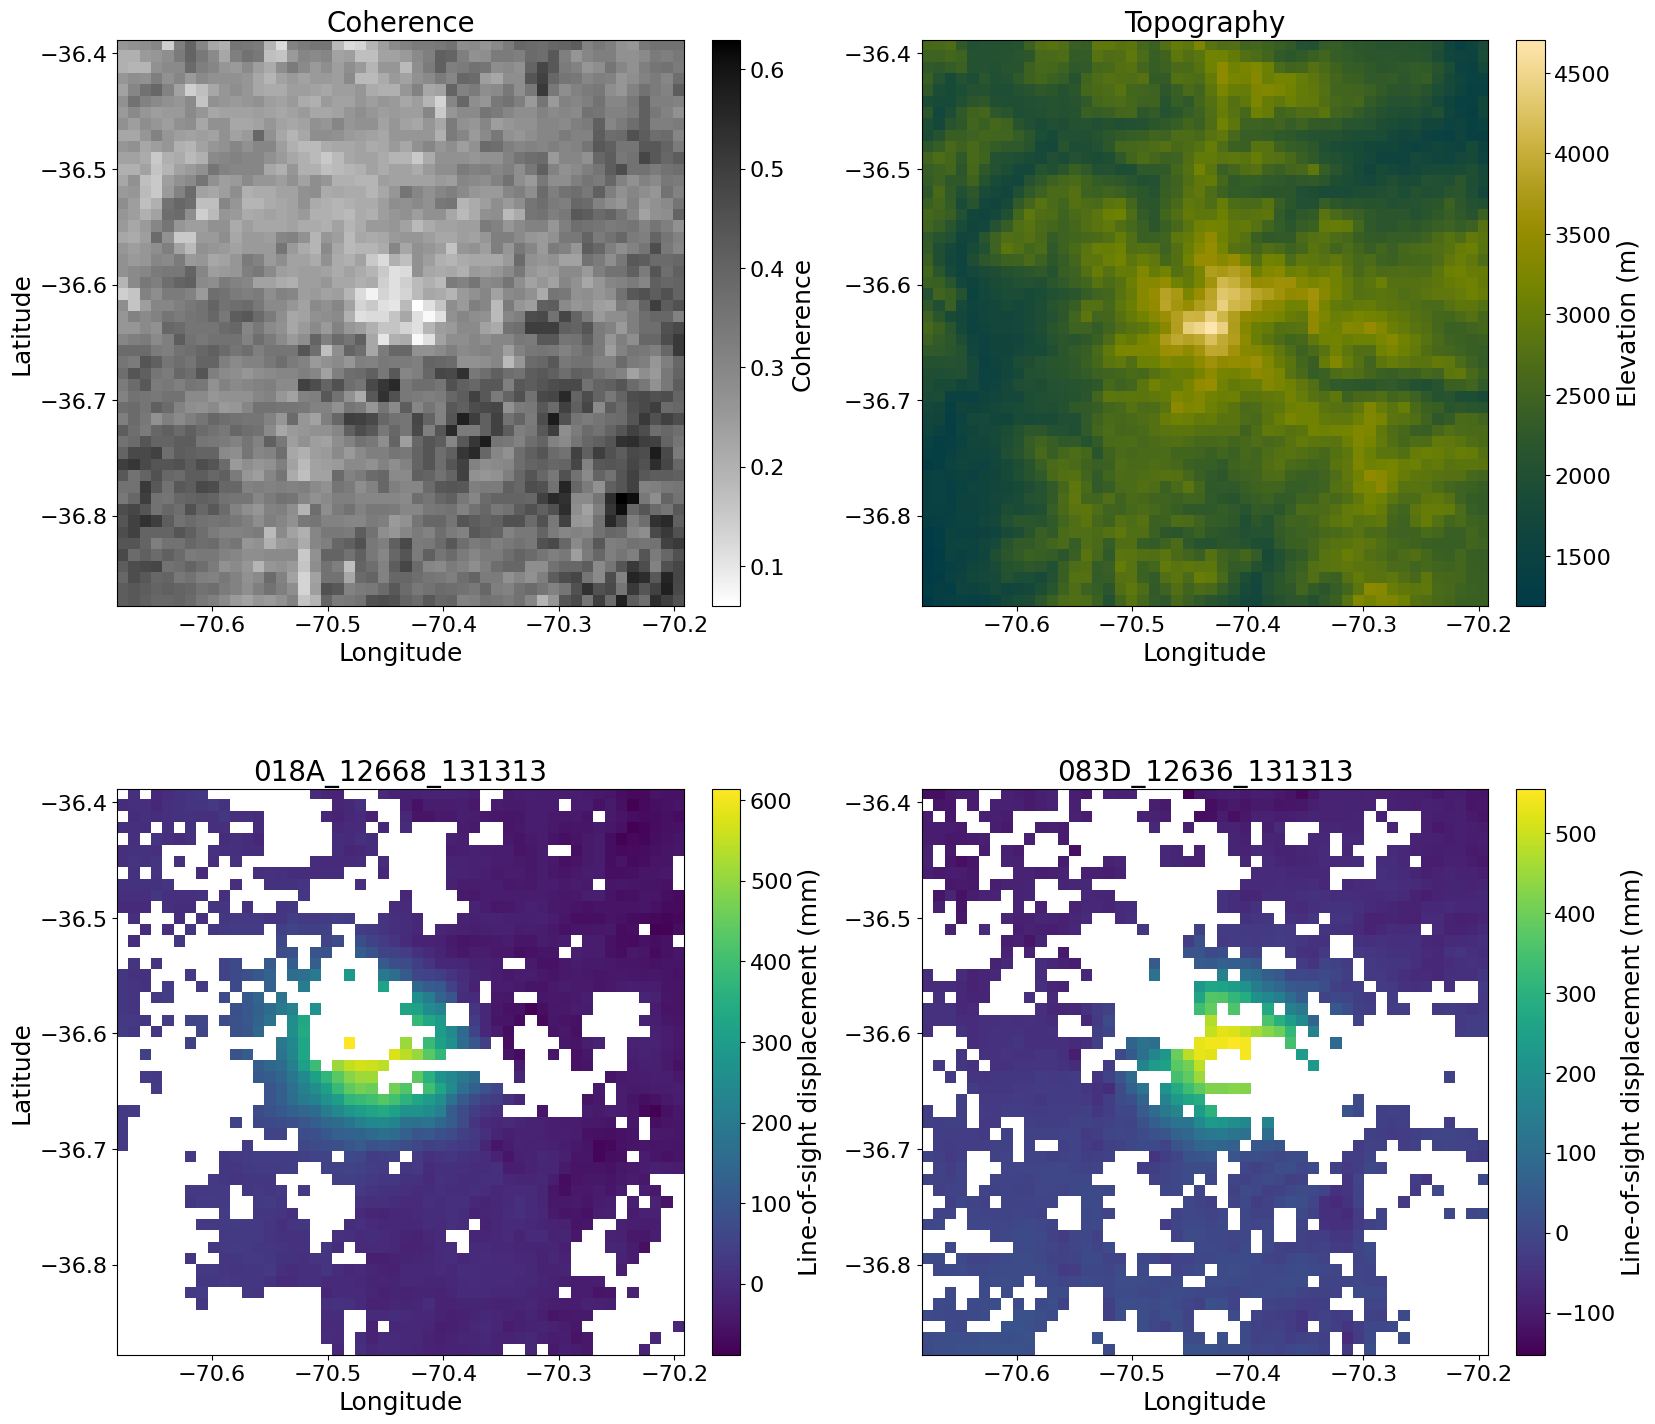

In [10]:
# use numpy to open the two csv files
input_asc = np.loadtxt('data/domuyo_018A_12668_131313_disp_raw.csv', delimiter=',', skiprows=1)
input_desc = np.loadtxt('data/domuyo_083D_12636_131313_disp_raw.csv', delimiter=',', skiprows=1)

# We can see that every grid position is included, with nan's used for padding,
# meaning we can simply reshape the columns into grids.

# get lat and lon coords by pulling the unique values from those columns
# these data are on the same grid, so we can use the ascending coords for both
lat = np.flip(np.unique(input_asc[:,0]))
lon = np.unique(input_asc[:,1])

# get axes limits
lat_min, lat_max = np.min(lat), np.max(lat)
lon_min, lon_max = np.min(lon), np.max(lon)

# reshape other columns into grids based on size on lat and lon
disp_asc = np.flipud(np.reshape(input_asc[:,2], (len(lat), len(lon))))
disp_desc = np.flipud(np.reshape(input_desc[:,2], (len(lat), len(lon))))

# same for coherence
coh_asc = np.flipud(np.reshape(input_asc[:,3], (len(lat), len(lon))))
coh_desc = np.flipud(np.reshape(input_desc[:,3], (len(lat), len(lon))))

# and same for elevation
elev_asc = np.flipud(np.reshape(input_asc[:,4], (len(lat), len(lon))))
elev_desc = np.flipud(np.reshape(input_desc[:,4], (len(lat), len(lon))))

# plot displacements, coherence, and elevation
fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.tight_layout(w_pad=10, h_pad=2)

# coherence (we'll just show the ascending, almost the same for both)
im = axs[0,0].imshow(coh_asc, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cm.grayC.reversed())
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Coherence', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0,0].set_title('Coherence', fontsize=20)
axs[0,0].set_xlabel('Longitude', fontsize=18)
axs[0,0].set_ylabel('Latitude', fontsize=18)
axs[0,0].tick_params(labelsize=16)

# topography (we'll just show the ascending, identical for both)
im = axs[0,1].imshow(elev_asc, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cm.bamako)
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Elevation (m)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0,1].set_title('Topography', fontsize=20)
axs[0,1].set_xlabel('Longitude', fontsize=18)
axs[0,1].tick_params(labelsize=16)

# ascending displacement
im = axs[1,0].imshow(disp_asc, extent=[lon_min, lon_max, lat_min, lat_max])
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1,0].set_title('018A_12668_131313', fontsize=20)
axs[1,0].set_xlabel('Longitude', fontsize=18)
axs[1,0].set_ylabel('Latitude', fontsize=18)
axs[1,0].tick_params(labelsize=16)

# descending displacement
im = axs[1,1].imshow(disp_desc, extent=[lon_min, lon_max, lat_min, lat_max])
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1,1].set_title('083D_12636_131313', fontsize=20)
axs[1,1].set_xlabel('Longitude', fontsize=18)
axs[1,1].tick_params(labelsize=16)

Let's now take a profile across the displacements from the ascending frame.

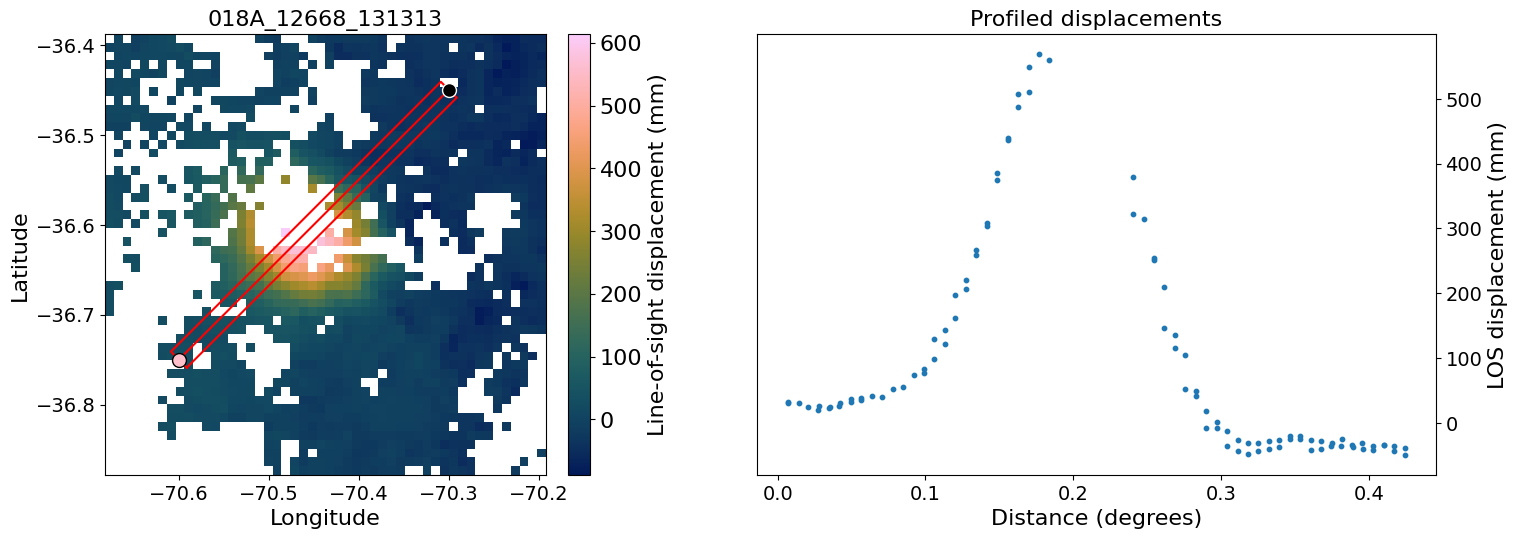

In [11]:
# start and end coordinates of the profile, and extra parameters
#####################################
prof_start = (-70.6, -36.75)
prof_end = (-70.3, -36.45)
prof_params = {
    "nbins": 100, # number of bins to split the profile into
    "width": 0.025 # total width of the profile in degrees (1 degree ~ 110 km)
}
#####################################

# run the profiler, the outputs are as follows:
# - bin_val = mean value of each bin
# - prof_bin_mids = distance along the profile to the middle of each bin
# - points_val = every velocity within the profile
# - points_dist = distance along the profile to every point within the profile
# - points_poly = polygon that defines the profile
bin_val, prof_bin_mids, points_val, points_dist, points_poly \
    = lib.profile_data(lon,lat,disp_asc,prof_start,prof_end,prof_params)

# plot the ascending displacements and the profiled data
fig, axs = plt.subplots(1,2,figsize=(15,5))
plt.tight_layout(w_pad=2)

# ascending map
im = axs[0].imshow(disp_asc, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cm.batlow)
axs[0].plot([prof_start[0], prof_end[0]], [prof_start[1], prof_end[1]], color="red")
axs[0].plot(points_poly[:,0],points_poly[:,1], color="red")
axs[0].scatter(prof_start[0],prof_start[1], s=100, color='pink', edgecolor='black', zorder=3)
axs[0].scatter(prof_end[0],prof_end[1], s=100, color='black', edgecolor='white', zorder=3)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=16)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('018A_12668_131313', fontsize=16)
axs[0].set_xlabel('Longitude', fontsize=16)
axs[0].set_ylabel('Latitude', fontsize=16)
axs[0].tick_params(labelsize=14)
axs[0].set_xlim(np.amin(lon), np.amax(lon))
axs[0].set_ylim(np.amin(lat), np.amax(lat))

# velocities projected onto profile
axs[1].scatter(points_dist, points_val, s=10)
axs[1].set_title('Profiled displacements', fontsize=16)
axs[1].set_xlabel("Distance (degrees)", fontsize=16)
axs[1].set_ylabel("LOS displacement (mm)", fontsize=16)
axs[1].tick_params(labelsize=14)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")

plt.show()

The left plot shows our line-of-sight displacements for 018A, where motion towards the satellite is positive. The start and end of our profile are marked with the pink and black dots, respectively. The three red lines show the middle and outside edge of the profile. The right plot is every pixel within the outer edges of our profile projected onto the profile line.

It would be useful if our data were in metres instead of degrees for modelling, so let's project from lat-long to UTM.

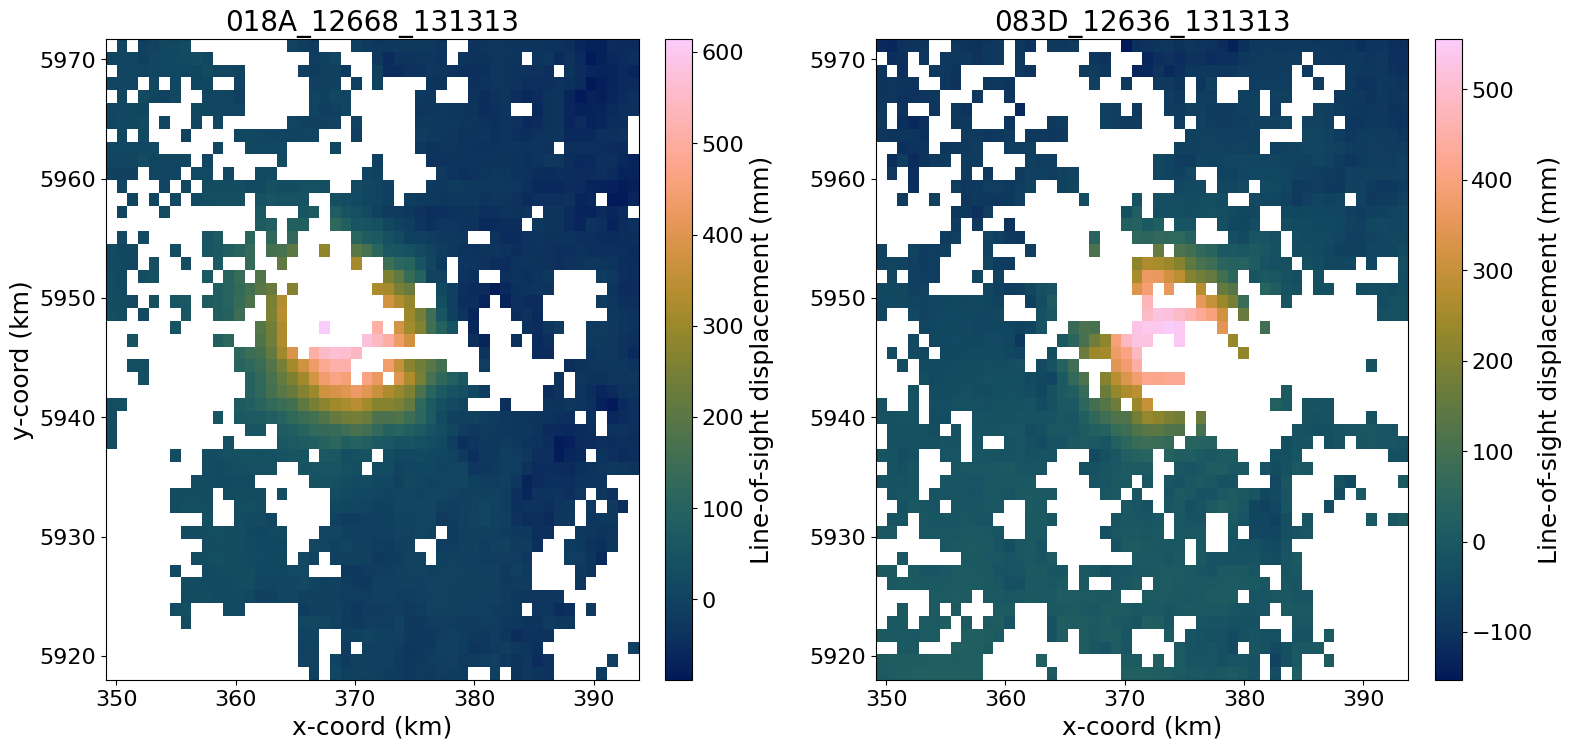

In [12]:
# get the utm zone projection
utm_crs_list = pyproj.database.query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest = pyproj.aoi.AreaOfInterest(
        west_lon_degree  = np.amin(lon),
        south_lat_degree = np.amin(lat),
        east_lon_degree  = np.amax(lon),
        north_lat_degree = np.amax(lat),
    ),
)
utm_crs = pyproj.CRS.from_epsg(utm_crs_list[0].code)

# create transformer for LL to UTM
transformer = pyproj.Transformer.from_crs('epsg:4326', utm_crs)

# apply transform to our grids of lat long coordinates
x_utm, y_utm = transformer.transform(lat, lon)
x_utm, y_utm = x_utm/1000, y_utm/1000 # convert to km
xx_utm, yy_utm = np.meshgrid(x_utm, y_utm)
x_utm_min, x_utm_max, y_utm_min, y_utm_max = np.amin(x_utm), np.amax(x_utm), np.amin(y_utm), np.amax(y_utm)

# plot with new coords
fig, axs = plt.subplots(1,2,figsize=(15,7))
plt.tight_layout(w_pad=5)

# ascending displacements
im = axs[0].imshow(disp_asc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('018A_12668_131313', fontsize=20)
axs[0].set_xlabel('x-coord (km)', fontsize=18)
axs[0].set_ylabel('y-coord (km)', fontsize=18)
axs[0].tick_params(labelsize=16)
axs[0].set_xlim(x_utm_min, x_utm_max)
axs[0].set_ylim(y_utm_min, y_utm_max)

# ascending displacements
im = axs[1].imshow(disp_desc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1].set_title('083D_12636_131313', fontsize=20)
axs[1].set_xlabel('x-coord (km)', fontsize=18)
axs[1].tick_params(labelsize=16)
axs[1].set_xlim(x_utm_min, x_utm_max)
axs[1].set_ylim(y_utm_min, y_utm_max)

plt.show()

We'll now run our forward model, projecting the modelled displacements into the line-of-sight for both frames. We'll plot the modelled displacements, the real displacements, and the residual between the two.

We can now use the Mogi forward model in this exercise to make a preliminary assessment of the depth and volume change of the geodetic source active at Domuyo. Edit the source location, volume (dV) and depth to reduce the magnitude of the residuals for both the ascending and descending data. Keep updating these values to get a small residual between the observed and modelled displacements.

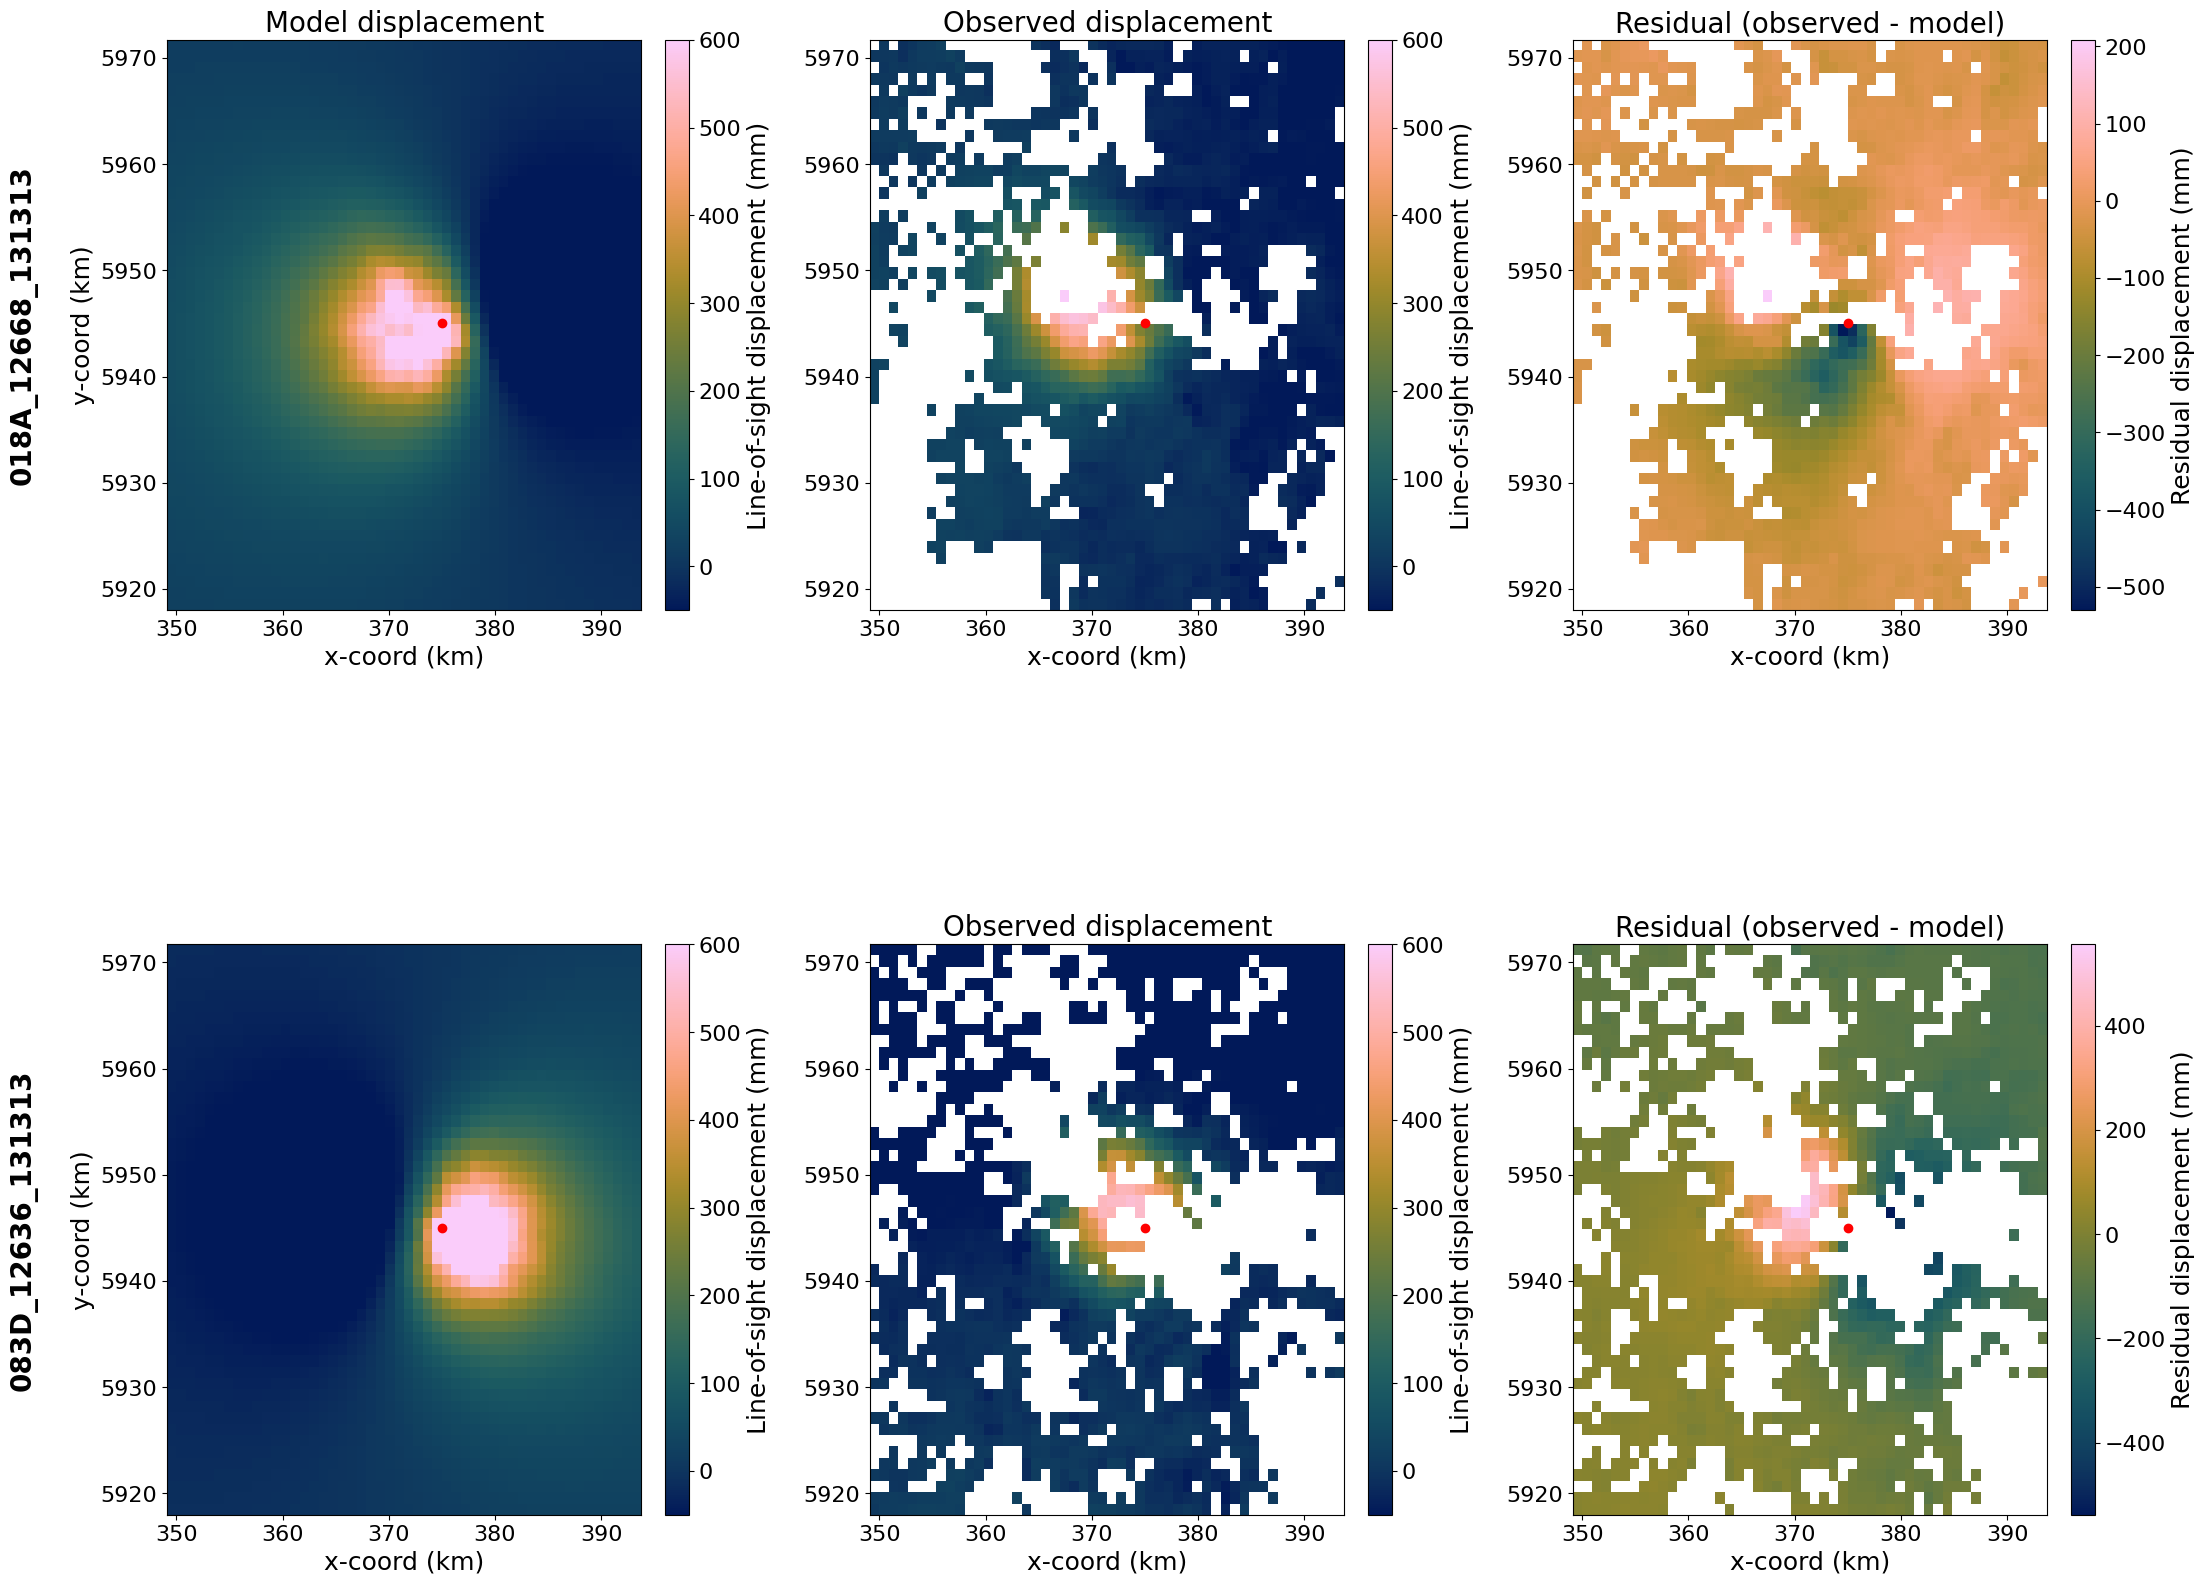

In [13]:
# setup model params
#####################################
source_depth = 5 # depth to point (km)
dV = 2e8 # change in volume (m^3)
xcen, ycen = 375, 5945
#####################################

# poisson's ratio for medium
nu = 0.25 

# shift topography so mean is at 0 m
elev_asc_shift = elev_asc - np.nanmean(elev_asc)

# run model
ux, uy, uz = lib.mogi_source_topo(xx_utm*1000, yy_utm*1000, elev_asc_shift, xcen=xcen*1000, ycen=ycen*1000, d=source_depth*1000, dV=dV, nu=nu)
ux, uy, uz = ux*1000, uy*1000, uz*1000

# heading and incidence angles
heading_asc, heading_desc = -170, -10 # degrees
incidence = 51 # degrees

# create grids of these angles
heading_grid_asc = np.ones(xx_utm.shape) * heading_asc
heading_grid_desc = np.ones(xx_utm.shape) * heading_desc
incidence_grid = np.ones(xx_utm.shape) * incidence

# generate conversions for each components to LOS (asc)
x2los_asc = np.cos(np.deg2rad(heading_grid_asc)) * np.sin(np.deg2rad(incidence_grid))
y2los_asc = np.sin(np.deg2rad(heading_grid_asc)) * np.sin(np.deg2rad(incidence_grid))
z2los_asc = np.cos(np.deg2rad(incidence_grid))

# same for desc
x2los_desc = np.cos(np.deg2rad(heading_grid_desc)) * np.sin(np.deg2rad(incidence_grid))
y2los_desc = np.sin(np.deg2rad(heading_grid_desc)) * np.sin(np.deg2rad(incidence_grid))
z2los_desc = np.cos(np.deg2rad(incidence_grid))

# calculate total displacement in los 
ulos_asc = (ux * x2los_asc) + (uy * y2los_asc) + (uz * z2los_asc)
ulos_desc = (ux * x2los_desc) + (uy * y2los_desc) + (uz * z2los_desc)

# plot comparison of model, observed, and residual displacements for both frames
extents = [x_utm_min, x_utm_max, y_utm_min, y_utm_max]
clim = [-50, 600]
lib.plot_comparison(ulos_asc, disp_asc, ulos_desc, disp_desc, xcen, ycen, extents, clim)


You are likely to have found that a Mogi model, even after an approximate topographic correction, only provides a very rough fit to these data.  There could be many reasons for this, including that the assumptions required by the Mogi model about crustal properties are too simple – e.g., the Earth is neither homogeneous nor purely elastic. It may also be that a point source is not the best geometry for modelling this uplift pattern (e.g., Figure 4).

<img src="figures/source_models.png" style="float: centre;" width="1000"/>

*Figure 5: Displacement patterns for analytical elastic half space sources for different geometries: (i) A Mogi source, (ii) An opening dyke and (iii) inflating sill (Okada sources) and a penny-shaped crack.*

In fact, the uplift at Domuyo between 2015 and 2019 is best fit by a slightly tilted, oblate tabular source with a centre depth of 6.5 km.   Lundgren et al., 2020 apply an inversion method that used compound dislocation models (Nikhoo et al, 2016) to find the best fit geometry for the source (see supplementary figures from Lundgren et al., 2020).   

## 5. Real world example - Dabbahu

Using the same code, plotting an ascending and descending frame, as well as coherence and topography of Dabbahu volcano, Ethiopia. 


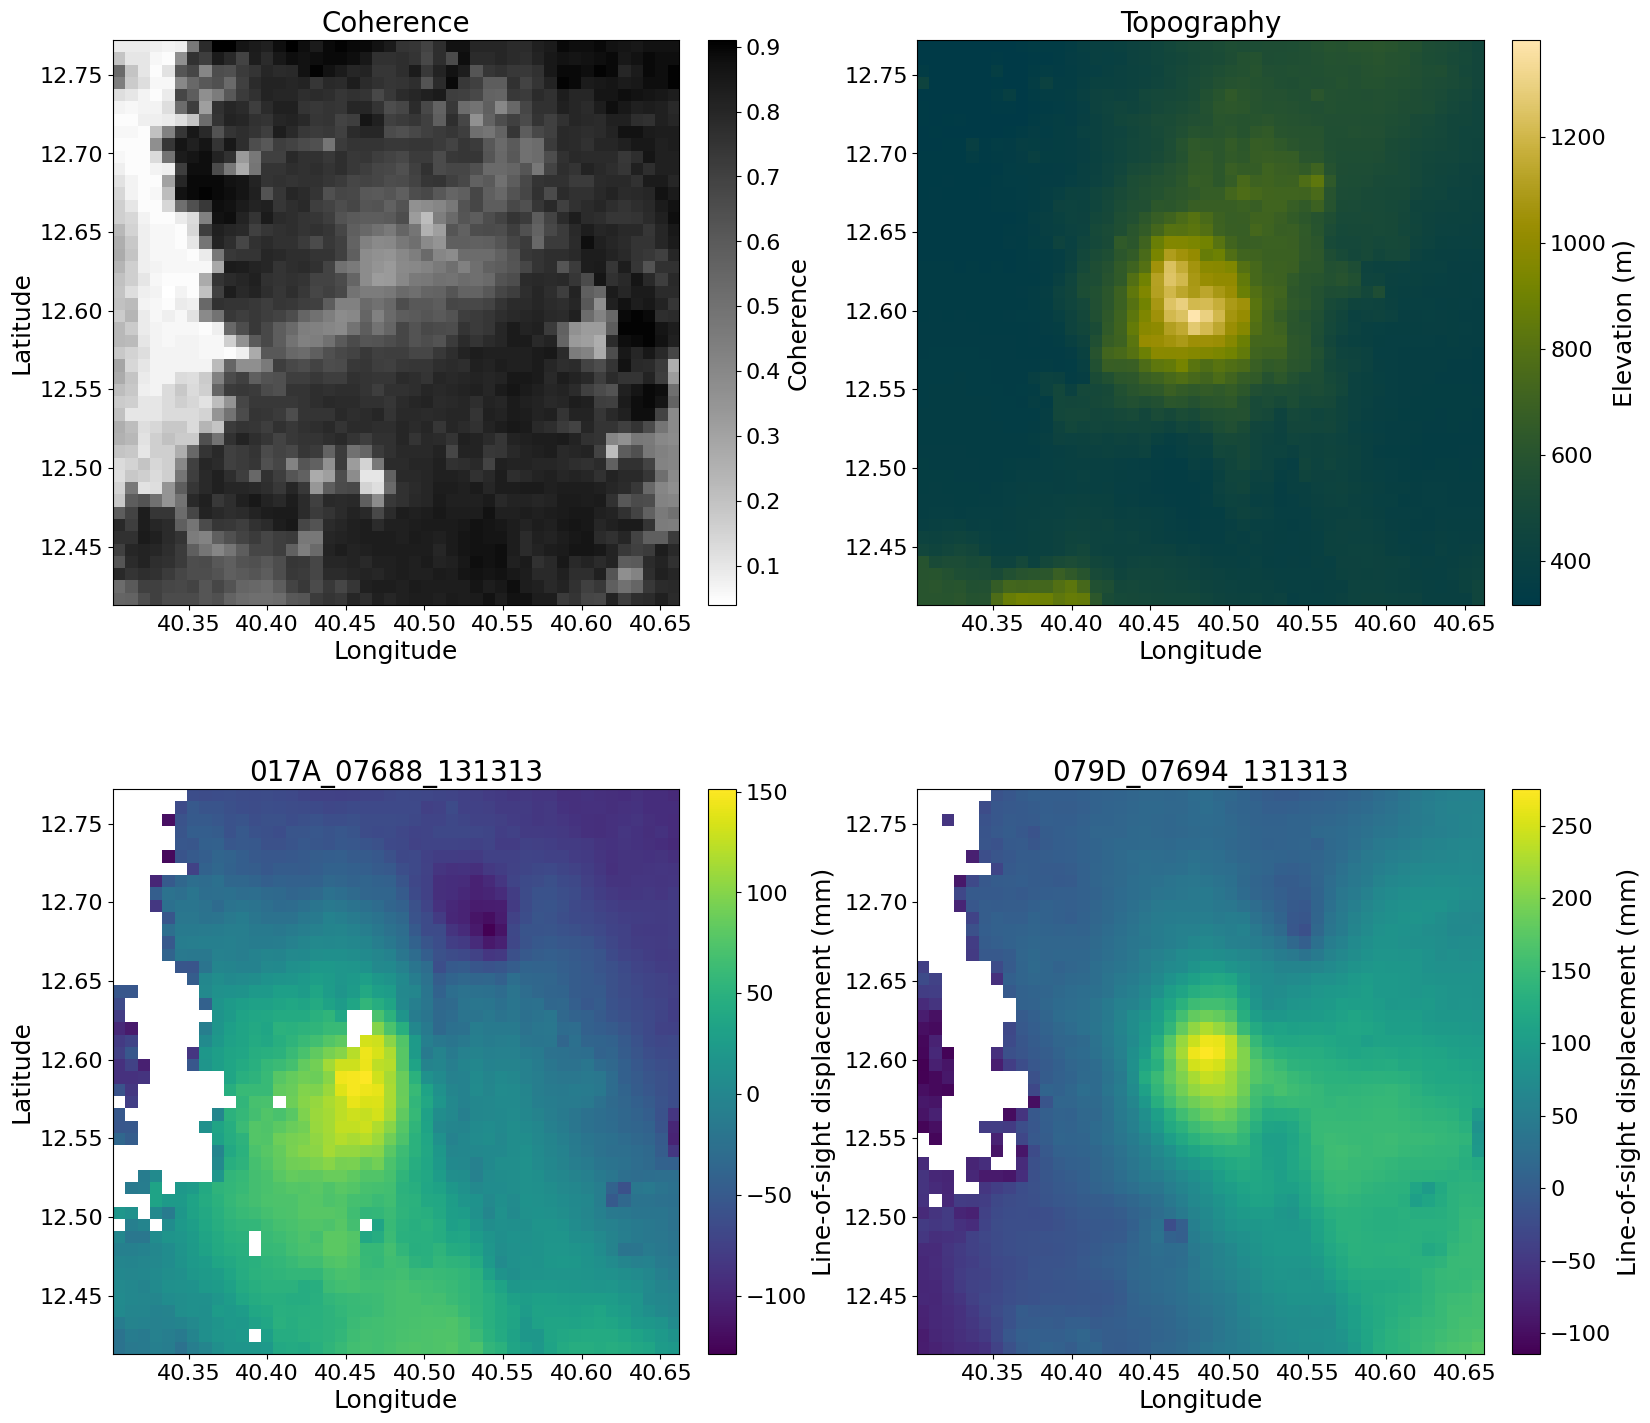

In [14]:
# use numpy to open the two csv files
input_asc = np.loadtxt('data/dabbahu_014A_07688_131313_disp_raw.csv', delimiter=',', skiprows=1)
input_desc = np.loadtxt('data/dabbahu_079D_07694_131313_disp_raw.csv', delimiter=',', skiprows=1)

# We can see that every grid position is included, with nan's used for padding,
# meaning we can simply reshape the columns into grids.

# get lat and lon coords by pulling the unique values from those columns
# these data are on the same grid, so we can use the ascending coords for both
lat = np.flip(np.unique(input_asc[:,0]))
lon = np.unique(input_asc[:,1])

# get axes limits
lat_min, lat_max = np.min(lat), np.max(lat)
lon_min, lon_max = np.min(lon), np.max(lon)

# reshape other columns into grids based on size on lat and lon
disp_asc = np.flipud(np.reshape(input_asc[:,2], (len(lat), len(lon))))
disp_desc = np.flipud(np.reshape(input_desc[:,2], (len(lat), len(lon))))

# same for coherence
coh_asc = np.flipud(np.reshape(input_asc[:,3], (len(lat), len(lon))))
coh_desc = np.flipud(np.reshape(input_desc[:,3], (len(lat), len(lon))))

# and same for elevation
elev_asc = np.flipud(np.reshape(input_asc[:,4], (len(lat), len(lon))))
elev_desc = np.flipud(np.reshape(input_desc[:,4], (len(lat), len(lon))))

# plot displacements, coherence, and elevation
fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.tight_layout(w_pad=10, h_pad=2)

# coherence (we'll just show the ascending, almost the same for both)
im = axs[0,0].imshow(coh_asc, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cm.grayC.reversed())
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Coherence', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0,0].set_title('Coherence', fontsize=20)
axs[0,0].set_xlabel('Longitude', fontsize=18)
axs[0,0].set_ylabel('Latitude', fontsize=18)
axs[0,0].tick_params(labelsize=16)

# topography (we'll just show the ascending, identical for both)
im = axs[0,1].imshow(elev_asc, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cm.bamako)
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Elevation (m)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0,1].set_title('Topography', fontsize=20)
axs[0,1].set_xlabel('Longitude', fontsize=18)
axs[0,1].tick_params(labelsize=16)

# ascending displacement
im = axs[1,0].imshow(disp_asc, extent=[lon_min, lon_max, lat_min, lat_max])
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1,0].set_title('017A_07688_131313', fontsize=20)
axs[1,0].set_xlabel('Longitude', fontsize=18)
axs[1,0].set_ylabel('Latitude', fontsize=18)
axs[1,0].tick_params(labelsize=16)

# descending displacement
im = axs[1,1].imshow(disp_desc, extent=[lon_min, lon_max, lat_min, lat_max])
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1,1].set_title('079D_07694_131313', fontsize=20)
axs[1,1].set_xlabel('Longitude', fontsize=18)
axs[1,1].tick_params(labelsize=16)

Once again, taking a profile from the ascending frame

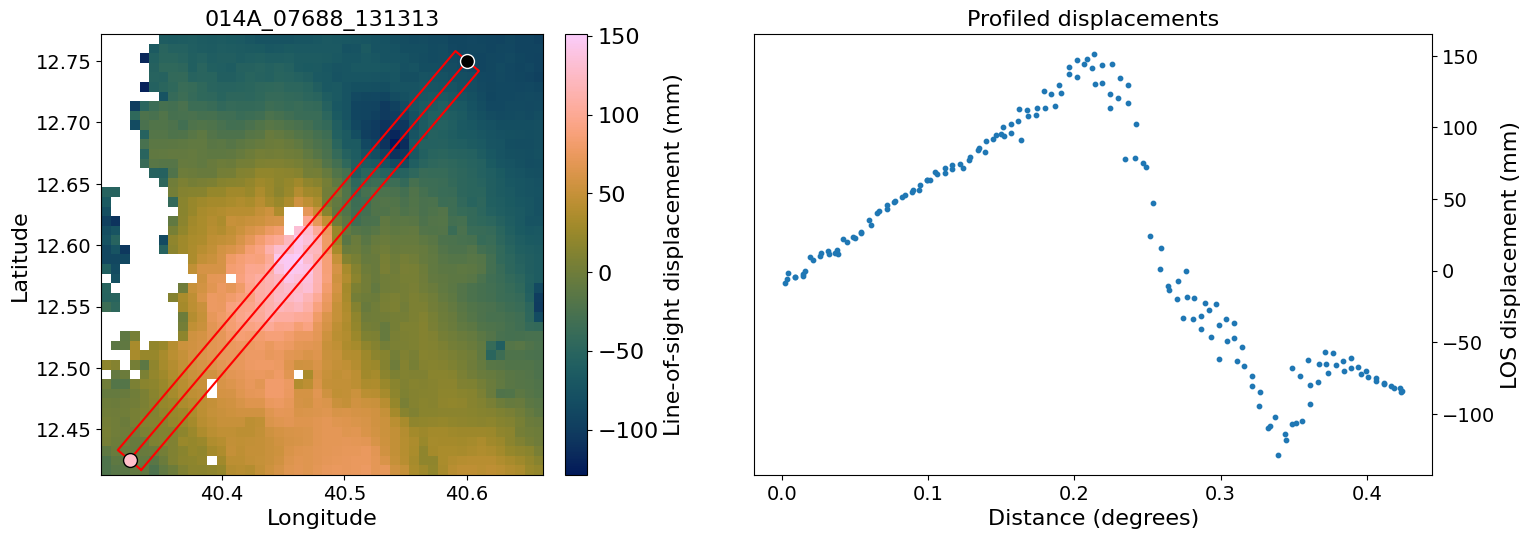

In [15]:
# start and end coordinates of the profile, and extra parameters
#####################################
prof_start = (40.325, 12.425)
prof_end = (40.6, 12.75)
prof_params = {
    "nbins": 100, # number of bins to split the profile into
    "width": 0.025 # total width of the profile in degrees (1 degree ~ 110 km)
}
#####################################

# run the profiler, the outputs are as follows:
# - bin_val = mean value of each bin
# - prof_bin_mids = distance along the profile to the middle of each bin
# - points_val = every velocity within the profile
# - points_dist = distance along the profile to every point within the profile
# - points_poly = polygon that defines the profile
bin_val, prof_bin_mids, points_val, points_dist, points_poly \
    = lib.profile_data(lon,lat,disp_asc,prof_start,prof_end,prof_params)

# plot the ascending displacements and the profiled data
fig, axs = plt.subplots(1,2,figsize=(15,5))
plt.tight_layout(w_pad=2)

# ascending map
im = axs[0].imshow(disp_asc, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cm.batlow)
axs[0].plot([prof_start[0], prof_end[0]], [prof_start[1], prof_end[1]], color="red")
axs[0].plot(points_poly[:,0],points_poly[:,1], color="red")
axs[0].scatter(prof_start[0],prof_start[1], s=100, color='pink', edgecolor='black', zorder=3)
axs[0].scatter(prof_end[0],prof_end[1], s=100, color='black', edgecolor='white', zorder=3)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=16)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('014A_07688_131313', fontsize=16)
axs[0].set_xlabel('Longitude', fontsize=16)
axs[0].set_ylabel('Latitude', fontsize=16)
axs[0].tick_params(labelsize=14)
axs[0].set_xlim(np.amin(lon), np.amax(lon))
axs[0].set_ylim(np.amin(lat), np.amax(lat))

# velocities projected onto profile
axs[1].scatter(points_dist, points_val, s=10)
axs[1].set_title('Profiled displacements', fontsize=16)
axs[1].set_xlabel("Distance (degrees)", fontsize=16)
axs[1].set_ylabel("LOS displacement (mm)", fontsize=16)
axs[1].tick_params(labelsize=14)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")

plt.show()

convert to UTM from lat-long again

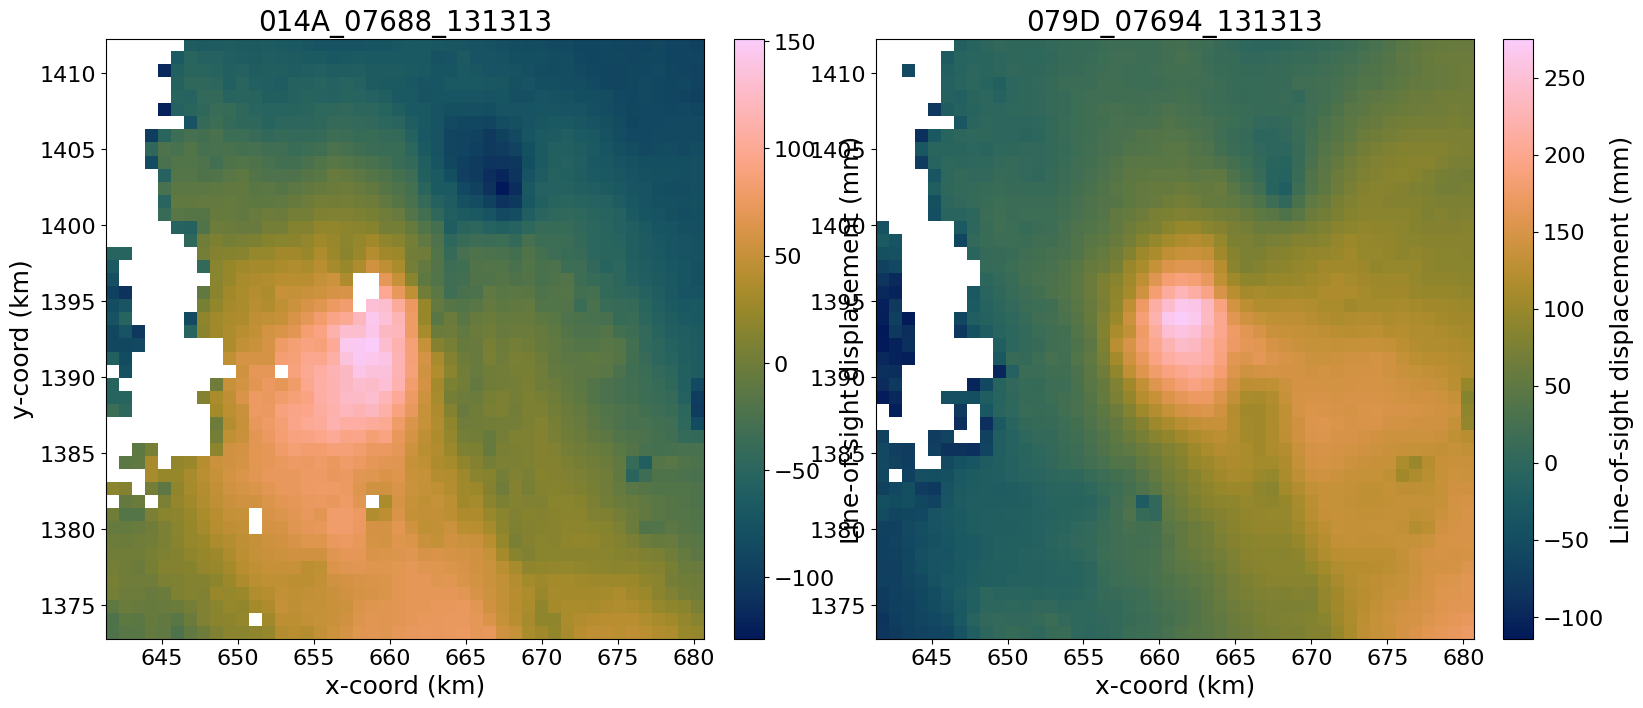

In [16]:
# get the utm zone projection
utm_crs_list = pyproj.database.query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest = pyproj.aoi.AreaOfInterest(
        west_lon_degree  = np.amin(lon),
        south_lat_degree = np.amin(lat),
        east_lon_degree  = np.amax(lon),
        north_lat_degree = np.amax(lat),
    ),
)
utm_crs = pyproj.CRS.from_epsg(utm_crs_list[0].code)

# create transformer for LL to UTM
transformer = pyproj.Transformer.from_crs('epsg:4326', utm_crs)

# apply transform to our grids of lat long coordinates
x_utm, y_utm = transformer.transform(lat, lon)
x_utm, y_utm = x_utm/1000, y_utm/1000 # convert to km
xx_utm, yy_utm = np.meshgrid(x_utm, y_utm)
x_utm_min, x_utm_max, y_utm_min, y_utm_max = np.amin(x_utm), np.amax(x_utm), np.amin(y_utm), np.amax(y_utm)

# plot with new coords
fig, axs = plt.subplots(1,2,figsize=(15,7))
plt.tight_layout(w_pad=5)

# ascending displacements
im = axs[0].imshow(disp_asc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[0].set_title('014A_07688_131313', fontsize=20)
axs[0].set_xlabel('x-coord (km)', fontsize=18)
axs[0].set_ylabel('y-coord (km)', fontsize=18)
axs[0].tick_params(labelsize=16)
axs[0].set_xlim(x_utm_min, x_utm_max)
axs[0].set_ylim(y_utm_min, y_utm_max)

# ascending displacements
im = axs[1].imshow(disp_desc, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max], cmap=cm.batlow)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad="5%")
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Line-of-sight displacement (mm)', fontsize=18)
cbar.ax.tick_params(labelsize=16)
axs[1].set_title('079D_07694_131313', fontsize=20)
axs[1].set_xlabel('x-coord (km)', fontsize=18)
axs[1].tick_params(labelsize=16)
axs[1].set_xlim(x_utm_min, x_utm_max)
axs[1].set_ylim(y_utm_min, y_utm_max)

plt.show()

And now we want to run our forward model for the proposed deformation source, this time as Okada (1985). 

In [1]:
# Define the coordinate grid and elastic parameters for our models.

# dimensions of grid in x (m)
xmin, xmax, xint = -30000, 30000, 100

# dimensions of grid in y (m)
ymin, ymax, yint = -30000, 30000, 100

# create coordinate grids
x = np.arange(xmin, xmax, xint)
y = np.arange(ymin, ymax, yint)
xx, yy = np.meshgrid(x, y)

# convert to pair of coordinates for our dislocation model
xx_vec = np.reshape(xx, -1)
yy_vec = np.reshape(yy, -1)

NameError: name 'np' is not defined

In [ ]:
# Generate and plot a simple strike-slip model

# Define the fault model
#####################################
xcen = 0          # vertical surface projection of fault centroid in x (m)
ycen = 0          # vertical surface projection of fault centroid in y (m)
strike = 90        # strike in degrees (0-360)
dip =    90         # dip in degrees (0-90)
rake =   0        # rake in degrees (-180 - 180)
slip =     1        # magnitude of slip vector in metres
centroid_depth = 6000       # depth (measured vertically) to fault centroid in metres
width = 8000    # width of fault measured along-dip in metres
length =  15000        # fault length in metres
#####################################

model = [xcen, ycen, strike, dip, rake, slip, length, centroid_depth, width]

# Calcualte displacements
disp = clib.disloc3d3(xx_vec, yy_vec, xoff=xcen, yoff=ycen, depth=centroid_depth,
                  length=length, width=width, slip=slip, opening=0, 
                   strike=strike, dip=dip, rake=rake, nu=0.25)

# Plot the three components of displacement
clib.plot_enu(disp, model, x, y)

In [ ]:
# Same again but for a thrust fault

# Define the fault model
#####################################
xcen = 0          # vertical surface projection of fault centroid in x (m)
ycen = 0          # vertical surface projection of fault centroid in y (m)
strike = 90        # strike in degrees (0-360)
dip =    45         # dip in degrees (0-90)
rake =   90        # rake in degrees (-180 - 180)
slip =     1        # magnitude of slip vector in metres
centroid_depth = 6000       # depth (measured vertically) to fault centroid in metres
width = 8000    # width of fault measured along-dip in metres
length =  15000        # fault length in metres
#####################################

model = [xcen, ycen, strike, dip, rake, slip, length, centroid_depth, width]

# Calcualte displacements
disp = clib.disloc3d3(xx_vec, yy_vec, xoff=xcen, yoff=ycen, depth=centroid_depth,
                  length=length, width=width, slip=slip, opening=0, 
                   strike=strike, dip=dip, rake=rake, nu=0.25)

# Plot the three components of displacement
clib.plot_enu(disp, model, x, y)

### References

Astort, A., Walter, T.R., Ruiz, F., Sagripanti, L., Nacif, A., Acosta, G. and Folguera, A., 2019. Unrest at Domuyo volcano, Argentina, detected by geophysical and geodetic data and morphometric analysis. Remote Sensing, 11(18), p.2175. 

Ebmeier, S.K., Andrews, B.J., Araya, M.C., Arnold, D.W.D., Biggs, J., Cooper, C., Cottrell, E., Furtney, M., Hickey, J., Jay, J.J.J.A.V. and Lloyd, R., 2018. Synthesis of global satellite observations of magmatic and volcanic deformation: implications for volcano monitoring & the lateral extent of magmatic domains. Journal of Applied Volcanology, 7(1), pp.1-26.

Lisowski, M., 2007. Analytical volcano deformation source models. In Volcano deformation (pp. 279-304). Springer, Berlin, Heidelberg.

Lundgren, P., Girona, T., Bato, M.G., Realmuto, V.J., Samsonov, S., Cardona, C., Franco, L., Gurrola, E. and Aivazis, M., 2020. The dynamics of large silicic systems from satellite remote sensing observations: The intriguing case of Domuyo volcano, Argentina. Scientific reports, 10(1), pp.1-15. 

Magee, C., Stevenson, C.T., Ebmeier, S.K., Keir, D., Hammond, J.O., Gottsmann, J.H., Whaler, K.A., Schofield, N., Jackson, C.A., Petronis, M.S. and O’driscoll, B., 2018. Magma plumbing systems: a geophysical perspective. Journal of Petrology, 59(6), pp.1217-1251. 

Masterlark, T., 2007. Magma intrusion and deformation predictions: Sensitivities to the Mogi assumptions. Journal of Geophysical Research: Solid Earth, 112(B6).

Mogi, K. 1958. Relations between the eruptions of various volcanoes and the deformations of the ground surfaces around them. Earthq Res Inst, 36, pp.99-134.

Nikkhoo, M., Walter, T. R., Lundgren, P. R. & Prats-Iraola, P. Compound dislocation models (CDMs) for volcano deformation analyses. Geophys. J. Int. 208, 877–894 (2016).

Pinel, V., Poland, M. P., & Hooper, A. (2014). Volcanology: Lessons learned from synthetic aperture radar imagery. Journal of Volcanology and Geothermal Research, 289, 81-113.

Segall, P. (2019). Magma chambers: what we can, and cannot, learn from volcano geodesy. Philosophical Transactions of the Royal Society A, 377(2139), 20180158

Williams, C.A. and Wadge, G., 1998. The effects of topography on magma chamber deformation models: Application to Mt. Etna and radar interferometry. Geophysical Research Letters, 25(10), pp.1549-1552.